In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('data.txt', delim_whitespace=True)
y = pd.read_csv('Y.txt', delim_whitespace=True) 
print(data.head())
print(y_data.head())

In [ ]:
data_calibration = data.iloc[:3000, :]
data_evaluation = data.iloc[3000:, :]
y_calibration = y_data.iloc[:3000, :]
y_evaluation = y_data.iloc[3000:, :]
print("Data loaded successfully.")
print("Shapes of data arrays:")
print(f"data: {data.shape}")
print(f"y: {y.shape}")
print(f"y_calibration: {y_calibration.shape}")
print(f"y_evaluation: {y_evaluation.shape}")

Data loaded and normalized successfully.
Shapes of data arrays:
data: (13150, 8)
y: (13150,)
y_calibration: (3000,)
y_evaluation: (10150,)
Optimized Weights: [0.00867987 0.20525115 0.0741639  0.06424059 0.00509332 0.03970112
 0.27362069 0.32924937]
Optimized Variances: [3.03543204e+00 6.85138412e-03 7.25309868e-02 5.48587303e-03
 2.29801772e-02 3.34032904e-01 1.71003036e-03 5.58374869e-03]
Final Log-Likelihood: 1876.1825640501897
Standard deviations (Calibration Period): [1.7183099  1.73425851 1.74700851 1.75720115 1.76534936 1.77186329
 1.77707092 1.78123442 1.78456339 1.78722534]
Standard deviations (Evaluation Period): [0.271622   0.49820506 0.74512814 0.916444   1.0180537  0.47370092
 0.16059783 0.39413789 0.60588446 0.82276139]
Calibration lower bounds: [-217.85538777 -219.92866732 -221.59463959 -222.93487122 -224.01458642
 -224.88593204 -225.59059561 -226.16190143 -226.62648724 -227.00564672]
Calibration upper bounds: [215.36292302 217.31058911 218.85913311 220.08865878 221.06325

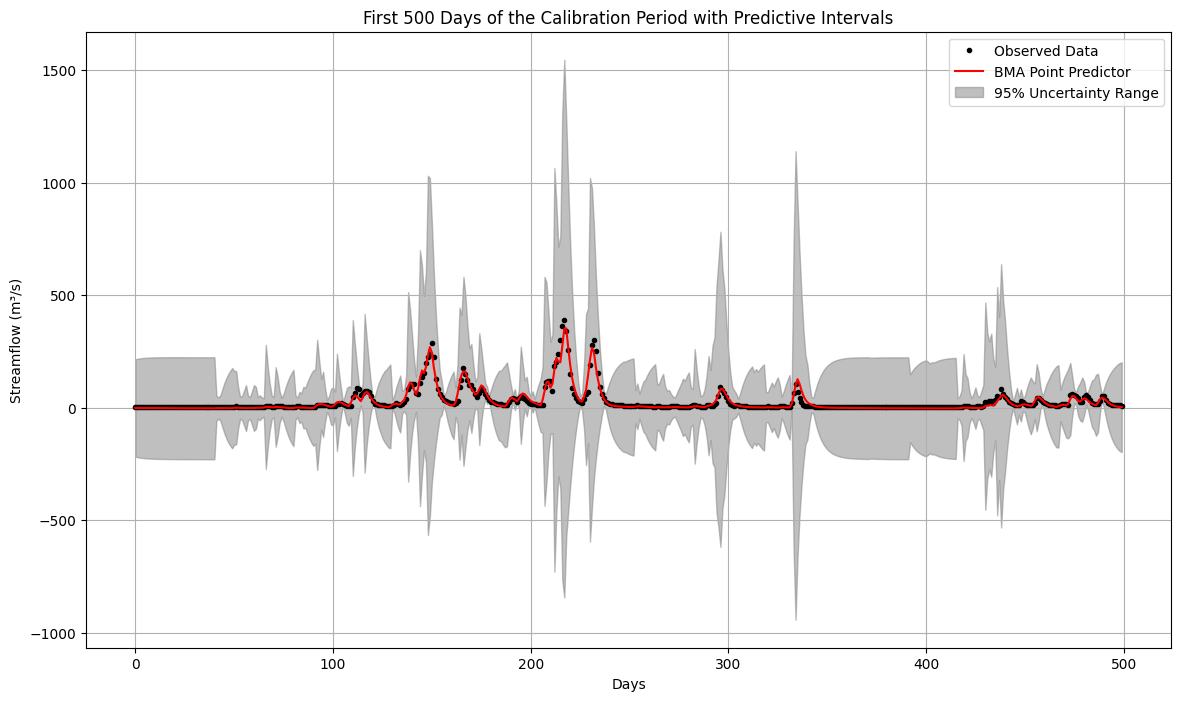

Percentage of measurements within 95% predictive intervals (Calibration Period): 99.80%
Percentage of measurements within 95% predictive intervals (Evaluation Period): 99.58%


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load the data using Pandas 
data_path = 'data.txt'
y_path = 'Y.txt'

# Read data into Pandas DF
data_df = pd.read_csv(data_path, delim_whitespace=True, header=None)
y_df = pd.read_csv(y_path, delim_whitespace=True, header=None)

# Convert to numpy arrays
data = data_df.values
y = y_df.values.flatten()  # Ensure y is a 1D 

# Normalize data
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data_normalized = (data - data_mean) / data_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

# Split the normalized Y data into calibration (first 3000 obs) and evaluation (remaining obs) sets
y_calibration = y_normalized[:3000]
y_evaluation = y_normalized[3000:]

# Split the normalized model data into calibration and evaluation sets
data_calibration = data_normalized[:3000, :]
data_evaluation = data_normalized[3000:, :]

print("Data loaded and normalized successfully.")
print("Shapes of data arrays:")
print(f"data: {data.shape}")
print(f"y: {y.shape}")
print(f"y_calibration: {y_calibration.shape}")
print(f"y_evaluation: {y_evaluation.shape}")

# Function to perform the Expectation-Maximization (EM) algorithm for BMA
def em_bma(y, data, max_iter=100, tol=1e-6):
    K = data.shape[1]  # Number of models
    
    # Initialize weights and variances
    weights = np.ones(K) / K
    variances = np.var(data, axis=0)
    
    log_likelihoods = []
    weights_trace = []
    variances_trace = []
    
    for iteration in range(max_iter):
        # E-Step: Calculate responsibilities
        responsibilities = np.zeros((len(y), K))
        for k in range(K):
            responsibilities[:, k] = weights[k] * norm.pdf(y, data[:, k], np.sqrt(variances[k]))
        
        sum_responsibilities = np.sum(responsibilities, axis=1, keepdims=True)
        responsibilities /= sum_responsibilities
        
        # M-Step: Update weights and variances
        weights = np.mean(responsibilities, axis=0)
        variances = np.sum(responsibilities * (y[:, None] - data) ** 2, axis=0) / np.sum(responsibilities, axis=0)
        
        # Normalize weights
        weights /= np.sum(weights)
        
        # Store weights and variances
        weights_trace.append(weights.copy())
        variances_trace.append(variances.copy())
        
        # Calculate log-likelihood
        log_likelihood = np.sum(np.log(sum_responsibilities))
        log_likelihoods.append(log_likelihood)
        
        # Check for convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    
    return weights, variances, log_likelihoods, weights_trace, variances_trace

# Run the EM algorithm
weights_em, variances_em, log_likelihoods_em, weights_trace_em, variances_trace_em = em_bma(y_calibration, data_calibration)

# Print the results
print("Optimized Weights:", weights_em)
print("Optimized Variances:", variances_em)
print("Final Log-Likelihood:", log_likelihoods_em[-1])

# Define a function to calculate the percentage of observations within the predictive intervals
def percentage_within_intervals(y, lower_bound, upper_bound):
    within_interval = np.sum((y >= lower_bound) & (y <= upper_bound))
    return (within_interval / len(y)) * 100

# Calculate the point predictor and standard deviations for the calibration period
calibration_point_predictor = np.dot(data_calibration, weights_em)
calibration_std_dev = np.sqrt(np.dot(np.square(data_calibration), variances_em))

# Calculate the lower and upper bounds for the calibration period
calibration_lower_bound = calibration_point_predictor - 1.96 * calibration_std_dev
calibration_upper_bound = calibration_point_predictor + 1.96 * calibration_std_dev

# Calculate the point predictor and standard deviations for the evaluation period
evaluation_point_predictor = np.dot(data_evaluation, weights_em)
evaluation_std_dev = np.sqrt(np.dot(np.square(data_evaluation), variances_em))

# Calculate the lower and upper bounds for the evaluation period
evaluation_lower_bound = evaluation_point_predictor - 1.96 * evaluation_std_dev
evaluation_upper_bound = evaluation_point_predictor + 1.96 * evaluation_std_dev

# Transform predictions back to original scale
calibration_point_predictor = calibration_point_predictor * y_std + y_mean
calibration_lower_bound = calibration_lower_bound * y_std + y_mean
calibration_upper_bound = calibration_upper_bound * y_std + y_mean

evaluation_point_predictor = evaluation_point_predictor * y_std + y_mean
evaluation_lower_bound = evaluation_lower_bound * y_std + y_mean
evaluation_upper_bound = evaluation_upper_bound * y_std + y_mean

# Print standard deviations to check their correctness
print("Standard deviations (Calibration Period):", calibration_std_dev[:10])
print("Standard deviations (Evaluation Period):", evaluation_std_dev[:10])

# Print the first 10 lower and upper bounds for verification
print("Calibration lower bounds:", calibration_lower_bound[:10])
print("Calibration upper bounds:", calibration_upper_bound[:10])
print("Evaluation lower bounds:", evaluation_lower_bound[:10])
print("Evaluation upper bounds:", evaluation_upper_bound[:10])

# Visualize intervals for the first 500 observations in the calibration period
plt.figure(figsize=(14, 8))
plt.plot(range(500), y_calibration[:500] * y_std + y_mean, 'ko', markersize=3, label='Observed Data')
plt.plot(range(500), calibration_point_predictor[:500], 'r-', label='BMA Point Predictor')
plt.fill_between(range(500), calibration_lower_bound[:500], calibration_upper_bound[:500], color='gray', alpha=0.5, label='95% Uncertainty Range')
plt.xlabel('Days')
plt.ylabel('Streamflow (m³/s)')
plt.title('First 500 Days of the Calibration Period with Predictive Intervals')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the percentage of measurements within the 95% predictive intervals for both periods
calibration_percentage = percentage_within_intervals(y_calibration * y_std + y_mean, calibration_lower_bound, calibration_upper_bound)
evaluation_percentage = percentage_within_intervals(y_evaluation * y_std + y_mean, evaluation_lower_bound, evaluation_upper_bound)

print(f"Percentage of measurements within 95% predictive intervals (Calibration Period): {calibration_percentage:.2f}%")
print(f"Percentage of measurements within 95% predictive intervals (Evaluation Period): {evaluation_percentage:.2f}%")


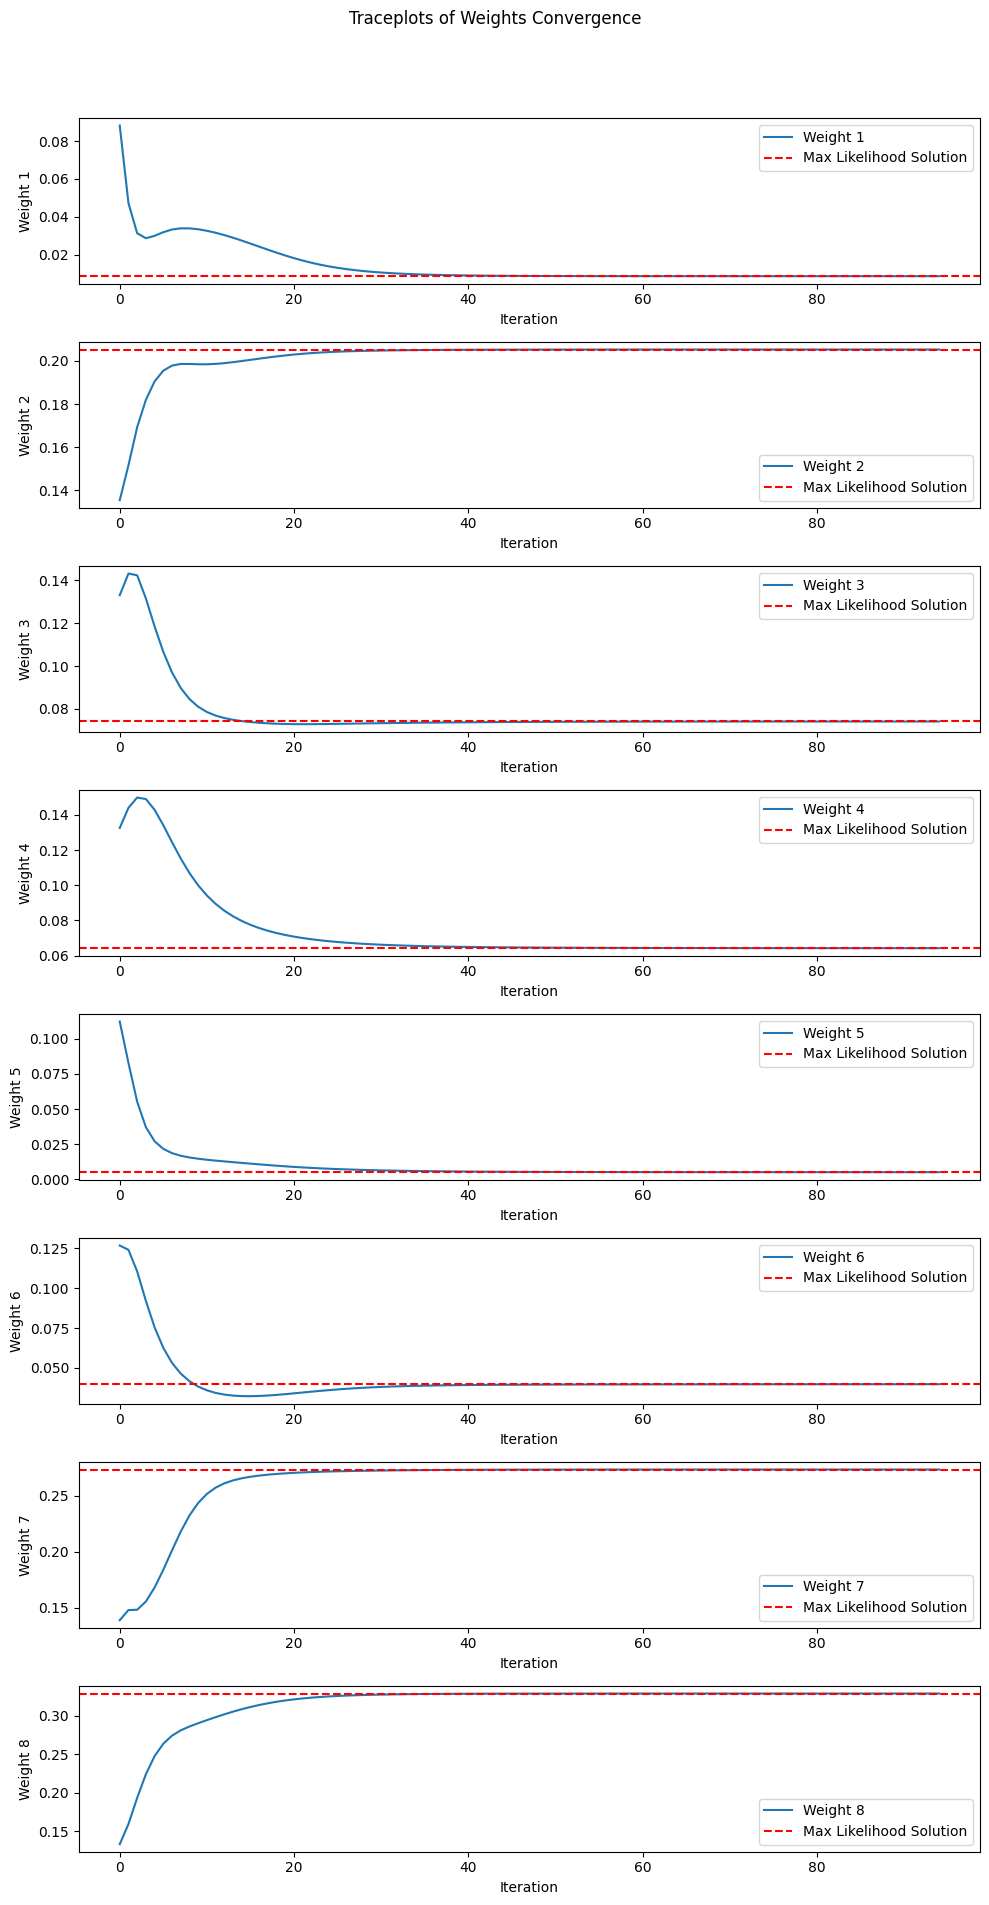

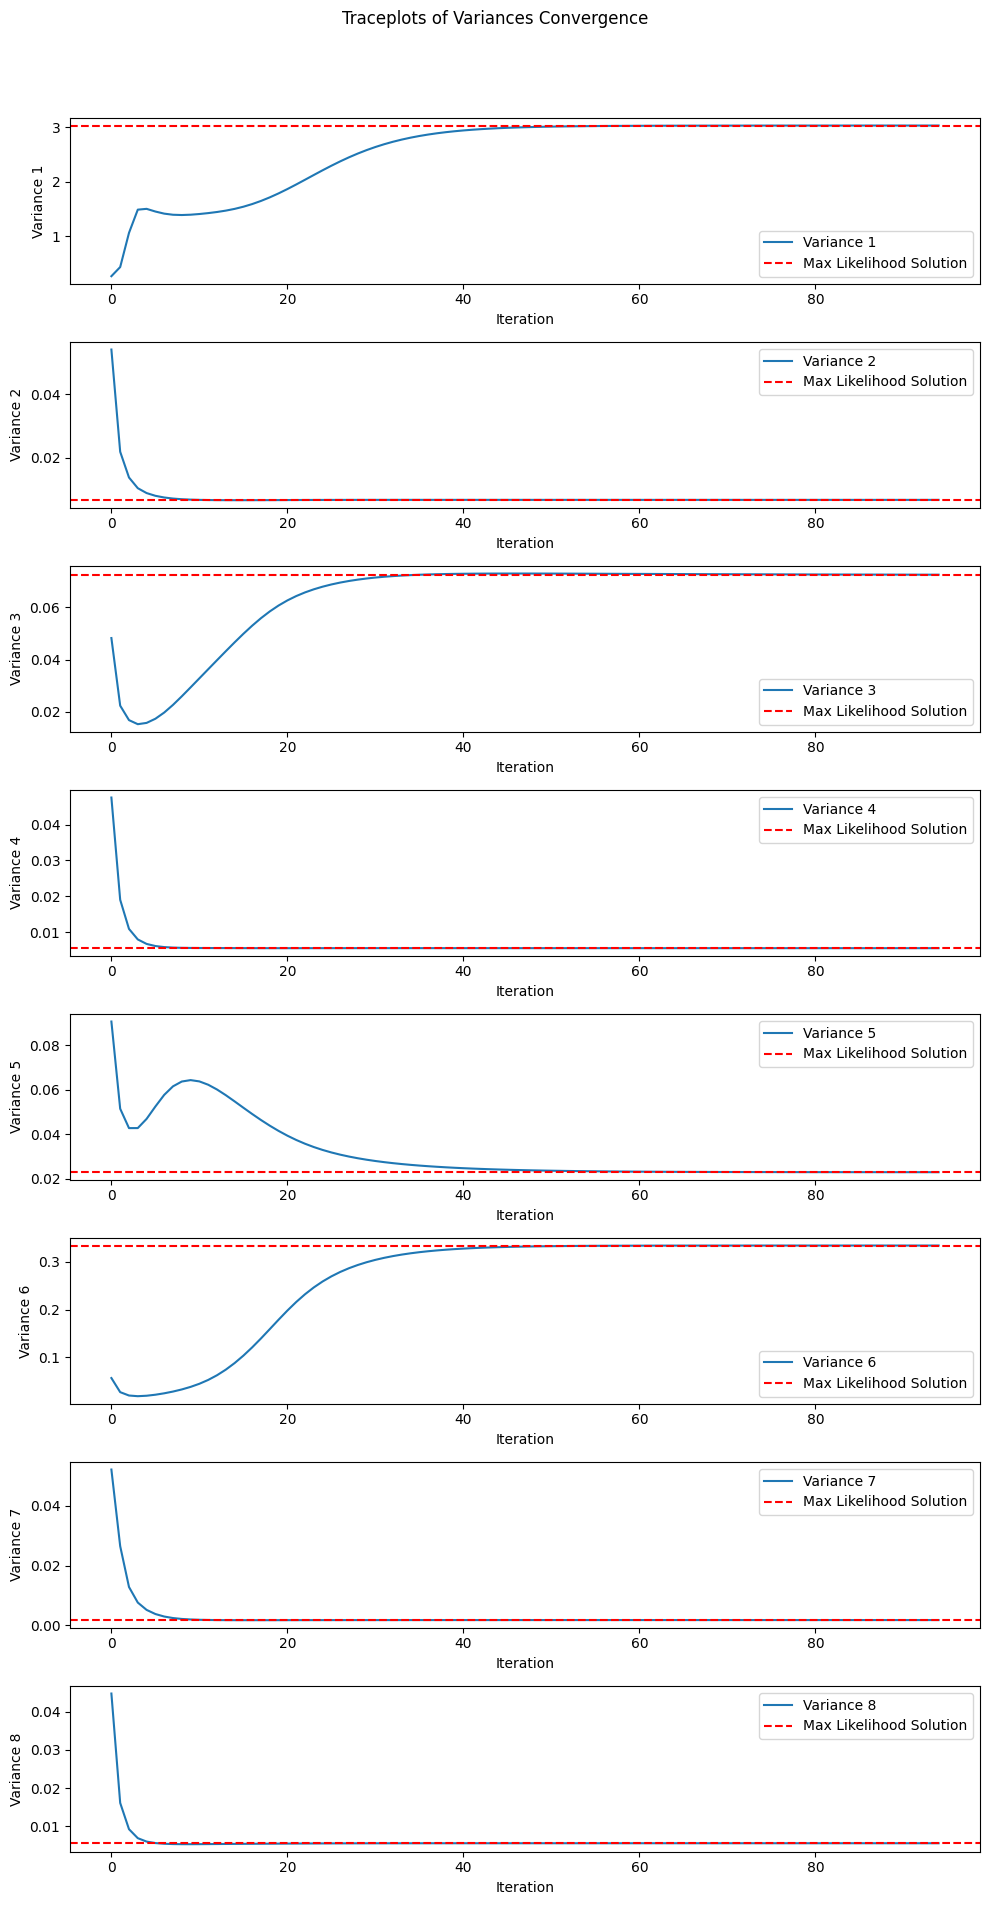

In [7]:
#2.7
import matplotlib.pyplot as plt

# Traceplot for weights
fig, axes = plt.subplots(len(weights_em), 1, figsize=(10, 20))
fig.suptitle('Traceplots of Weights Convergence')

for i in range(len(weights_em)):
    axes[i].plot(range(len(weights_trace_em)), [w[i] for w in weights_trace_em], label=f'Weight {i+1}')
    axes[i].axhline(y=weights_em[i], color='r', linestyle='--', label='Max Likelihood Solution')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(f'Weight {i+1}')
    axes[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Traceplot for variances
fig, axes = plt.subplots(len(variances_em), 1, figsize=(10, 20))
fig.suptitle('Traceplots of Variances Convergence')

for i in range(len(variances_em)):
    axes[i].plot(range(len(variances_trace_em)), [v[i] for v in variances_trace_em], label=f'Variance {i+1}')
    axes[i].axhline(y=variances_em[i], color='r', linestyle='--', label='Max Likelihood Solution')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(f'Variance {i+1}')
    axes[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


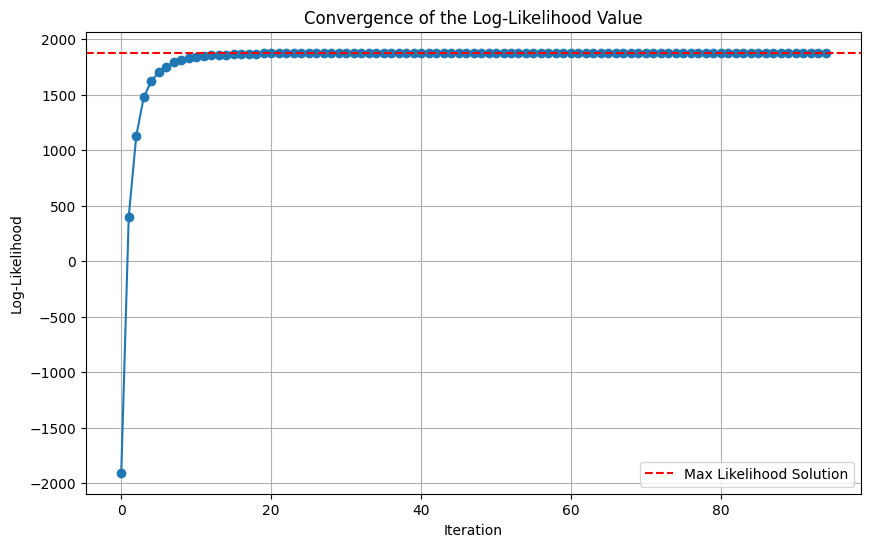

In [8]:
#2.8
# Traceplot of log-likelihood convergence
plt.figure(figsize=(10, 6))
plt.plot(range(len(log_likelihoods_em)), log_likelihoods_em, marker='o', linestyle='-')
plt.axhline(y=log_likelihoods_em[-1], color='r', linestyle='--', label='Max Likelihood Solution')
plt.title('Convergence of the Log-Likelihood Value')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
#2.12
# Define a function to calculate the percentage of observations within the predictive intervals
def percentage_within_intervals(y, lower_bound, upper_bound):
    within_interval = np.sum((y >= lower_bound) & (y <= upper_bound))
    return (within_interval / len(y)) * 100

# Calculate the point predictor and standard deviations for the calibration period
calibration_point_predictor = np.dot(data_calibration, weights_em)
calibration_std_dev = np.sqrt(np.dot(np.square(data_calibration), variances_em))

# Calculate the lower and upper bounds for the calibration period
calibration_lower_bound = calibration_point_predictor - 1.96 * calibration_std_dev
calibration_upper_bound = calibration_point_predictor + 1.96 * calibration_std_dev

# Calculate the point predictor and standard deviations for the evaluation period
evaluation_point_predictor = np.dot(data_evaluation, weights_em)
evaluation_std_dev = np.sqrt(np.dot(np.square(data_evaluation), variances_em))

# Calculate the lower and upper bounds for the evaluation period
evaluation_lower_bound = evaluation_point_predictor - 1.96 * evaluation_std_dev
evaluation_upper_bound = evaluation_point_predictor + 1.96 * evaluation_std_dev

# Transform predictions back to original scale
calibration_point_predictor = calibration_point_predictor * y_std + y_mean
calibration_lower_bound = calibration_lower_bound * y_std + y_mean
calibration_upper_bound = calibration_upper_bound * y_std + y_mean

evaluation_point_predictor = evaluation_point_predictor * y_std + y_mean
evaluation_lower_bound = evaluation_lower_bound * y_std + y_mean
evaluation_upper_bound = evaluation_upper_bound * y_std + y_mean

# Calculate the percentage of measurements within the 95% predictive intervals for both periods
calibration_percentage = percentage_within_intervals(y_calibration * y_std + y_mean, calibration_lower_bound, calibration_upper_bound)
evaluation_percentage = percentage_within_intervals(y_evaluation * y_std + y_mean, evaluation_lower_bound, evaluation_upper_bound)

print(f"Percentage of measurements within 95% predictive intervals (Calibration Period): {calibration_percentage:.2f}%")
print(f"Percentage of measurements within 95% predictive intervals (Evaluation Period): {evaluation_percentage:.2f}%")


Percentage of measurements within 95% predictive intervals (Calibration Period): 99.80%
Percentage of measurements within 95% predictive intervals (Evaluation Period): 99.58%


In [ ]:
#2.9
import pandas as pd

# Model names and parameters (based on the table provided in the homework)
models = ["ABC", "GR4J", "HYMOD", "TOPMO", "AWBM", "NAM", "HBV", "SAC-SMA"]
num_parameters = [3, 4, 5, 8, 8, 9, 9, 13]

# Optimized weights and variances from the EM algorithm
weights_em = [0.00867987, 0.20525115, 0.0741639, 0.06424059, 0.00509332, 0.03970112, 0.27362069, 0.32924937]
variances_em = [3.03543204, 0.00685138, 0.07253099, 0.00548587, 0.02298018, 0.3340329, 0.00171003, 0.00558375]

# Create a DataFrame to display the results
df = pd.DataFrame({
    "Model": models,
    "# Parameters": num_parameters,
    "β̂_BMA": weights_em,
    "σ̂_BMA": variances_em
})

# Print the DF
print(df)



In [ ]:
#2.9 with DE-MC
import numpy as np
import pandas as pd
from scipy.stats import norm

# Define the log-likelihood function
def log_likelihood(params, y, data):
    K = data.shape[1]
    weights = params[:K]
    variances = params[K:]
    weights /= np.sum(weights)  # Ensure weights sum to 1
    ll = 0
    for t in range(len(y)):
        mixture = 0
        for k in range(K):
            mixture += weights[k] * norm.pdf(y[t], data[t, k], np.sqrt(variances[k]))
        ll += np.log(mixture)
    return ll

# DE-MC algorithm
def de_mc(y, data, n_iter=10000, pop_size=20, crossover_rate=0.7, step_size=0.001):
    K = data.shape[1]
    params_dim = 2 * K
    population = np.random.rand(pop_size, params_dim)
    population[:, :K] /= np.sum(population[:, :K], axis=1)[:, np.newaxis]  # Normalize weights
    population[:, K:] *= 5 * np.std(y)  # Scale variances
    log_likelihoods = np.array([log_likelihood(p, y, data) for p in population])
    
    best_idx = np.argmax(log_likelihoods)
    best_params = population[best_idx]
    
    trace = []
    
    for iteration in range(n_iter):
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = population[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + step_size * (b - c), 0, 1)
            mutant[:K] /= np.sum(mutant[:K])  # Normalize weights
            mutant[K:] *= 5 * np.std(y)  # Scale variances
            crossover = np.random.rand(params_dim) < crossover_rate
            trial = np.where(crossover, mutant, population[i])
            trial_log_likelihood = log_likelihood(trial, y, data)
            if trial_log_likelihood > log_likelihoods[i]:
                population[i] = trial
                log_likelihoods[i] = trial_log_likelihood
                
        best_idx = np.argmax(log_likelihoods)
        best_params = population[best_idx]
        trace.append(best_params)
    
    return best_params, trace

# Load the data
data_path = 'data.txt'
y_path = 'Y.txt'
data_df = pd.read_csv(data_path, delim_whitespace=True, header=None)
y_df = pd.read_csv(y_path, delim_whitespace=True, header=None)
data = data_df.values
y = y_df.values.flatten()

# Normalize data
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data_normalized = (data - data_mean) / data_std
y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

# Split the normalized Y data into calibration (first 3000 observations) and evaluation (remaining observations) sets
y_calibration = y_normalized[:3000]
y_evaluation = y_normalized[3000:]
data_calibration = data_normalized[:3000, :]
data_evaluation = data_normalized[3000:, :]

# Run the DE-MC algorithm
best_params, trace = de_mc(y_calibration, data_calibration)

# Extract the best weights and variances
K = data_calibration.shape[1]
best_weights = best_params[:K]
best_variances = best_params[K:]

# Transform parameters back to original scale
best_variances *= (y_std ** 2)

# Create a DataFrame to display the results
models = ["ABC", "GR4J", "HYMOD", "TOPMO", "AWBM", "NAM", "HBV", "SAC-SMA"]
num_parameters = [3, 4, 5, 8, 8, 9, 9, 13]
df = pd.DataFrame({
    "Model": models,
    "# Parameters": num_parameters,
    "β̂_BMA": best_weights,
    "σ̂_BMA": best_variances
})

# Print the DataFrame
print(df)

